In [2]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
import pandas as pd
from pandas import DataFrame, Series
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
sns.set(style='ticks', palette='Set2')
%matplotlib inline

In [4]:
# Generate data
np.random.seed(7)

n_samples, n_features = 100, 200
X = np.random.randn(n_samples, n_features)

k = 5
# beta generated with k nonzeros
#coef = 10 * np.random.randn(n_features)
coef = 10 * np.ones(n_features)
inds = np.arange(n_features)
np.random.shuffle(inds)
coef[inds[k:]] = 0  # sparsify coef
y = np.dot(X, coef)

# add noise
y += 0.01 * np.random.normal((n_samples,))

# Split data in train set and test set
n_samples = X.shape[0]
X_train, y_train = X[:25], y[:25]
X_test, y_test = X[25:], y[25:]

In [34]:
# Problem 2

In [45]:
#2.1
#Step forward feature selection starts with the evaluation of each individual feature, 
#and selects that which results in the best performing selected algorithm model

alpha = 0.2
train_samples = 25
test_samples = 75


## Lecture 8 explains idea - we need to project y onto the feature then replace y with the residual
# use this to find the best error
def evaluate_feature_error(feature_train, feature_test, y_train=y_train, y_test=y_test, alpha=alpha, train_samples=train_samples, test_samples=test_samples):
    bias = alpha*np.eye(feature_train.shape[1])
    inverse = np.linalg.inv(np.dot(feature_train.T, feature_train)) + bias
    proj_1 = np.dot(feature_train.T, np.reshape(y_train, (train_samples,1)))
    beta_hat = np.dot(inverse, proj_1)
    proj_2 = np.reshape(y_test, (test_samples,1))
    error_vec = proj_2 - np.dot(feature_test, beta_hat)
    
    return np.linalg.norm(error_vec, ord=2)**2


    

feature_selection = []
errors = [None for i in range(0,n_features)]
best_scores = [] # best scores will save all the minimum errors from the feature selection

train_shape = (train_samples, 1)
test_shape = (test_samples, 1) 

for i in range(0, n_features):
    
    bias_train = np.ones(train_shape)
    bias_test = np.ones(test_shape)
    
    if len(feature_selection) == 0:
        X_feat_train = bias_train
        X_feat_test = bias_test
        
    else:
    
        for old_feat in feature_selection:
        
            old_feat_train = np.reshape(X_train[:,old_feat], train_shape)
            old_feat_test = np.reshape(X_test[:,old_feat], test_shape)
            X_feat_train = np.hstack((bias_train, old_feat_train))
            X_feat_test = np.hstack((bias_test, old_feat_test))
            
            
    for new_feat in range(0, n_features):
        if new_feat not in feature_selection:
            
            new_feat_train = np.reshape(X_train[:,new_feat], train_shape)
            new_feat_test = np.reshape(X_test[:,new_feat], test_shape)
                
            feature_train = np.hstack((X_feat_train, new_feat_train))
            feature_test = np.hstack((X_feat_test, new_feat_test))
                
            errors[new_feat] = evaluate_feature_error(feature_train, feature_test)
                
        
    min_error = min([i for i in errors if i is not None])
    selected_feature = errors.index(min_error)
   # print(selected_feature)
    feature_selection.append(selected_feature)
    best_scores.append(min_error)
    errors = [None for i in range(0,n_features)] # reset the errors
            

print("The order of the features is:")
print(feature_selection)

#print(len(feature_selection) == len(set(feature_selection)))

The order of the features is:
[138, 79, 108, 116, 166, 54, 163, 89, 194, 35, 113, 131, 130, 74, 160, 154, 95, 118, 90, 103, 167, 32, 180, 26, 36, 2, 68, 162, 135, 97, 91, 52, 13, 187, 44, 192, 179, 117, 188, 144, 119, 37, 47, 149, 29, 127, 101, 7, 28, 139, 141, 43, 94, 146, 189, 92, 198, 129, 31, 159, 60, 99, 122, 51, 12, 110, 62, 45, 140, 64, 121, 61, 88, 115, 169, 14, 148, 3, 65, 145, 5, 120, 58, 55, 105, 171, 137, 0, 151, 181, 83, 70, 33, 143, 16, 184, 104, 4, 77, 8, 190, 153, 107, 63, 40, 170, 81, 19, 30, 75, 132, 53, 193, 158, 9, 123, 172, 136, 174, 157, 165, 84, 176, 69, 10, 100, 196, 59, 133, 18, 82, 183, 6, 76, 22, 98, 109, 1, 24, 186, 87, 93, 102, 71, 73, 199, 48, 85, 39, 86, 38, 17, 66, 57, 126, 155, 164, 168, 80, 177, 25, 152, 21, 161, 124, 134, 106, 156, 46, 128, 150, 147, 111, 27, 41, 175, 185, 112, 11, 42, 23, 49, 182, 56, 34, 125, 197, 195, 78, 67, 191, 173, 114, 20, 142, 50, 72, 178, 15, 96]


We can use this to recover the true support. We need to find the feature with the minimal test-error
Index 1 error = 30052.233103646926


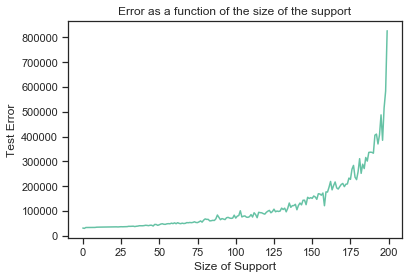

In [70]:
#2.2
#Plot test error as a function of the size of the support.  Can you use this to recover the true support?

txt = plt.plot(best_scores)
txt = plt.xlabel("Size of Support")
txt = plt.ylabel("Test Error")
txt = plt.title("Error as a function of the size of the support")

print("We can use this to recover the true support. We need to find the feature with the minimal test-error")
print("Index " + str(best_scores.index(min(best_scores))) +  " error = " + str(min(best_scores)))

In [78]:
# 2.3
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import Lasso

alphas = np.logspace(-4, -0.5, 30)
lasso = Lasso(random_state=0, max_iter=10000)

tuned_parameters = [{'alpha': alphas}]
n_folds = 5

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, scoring='r2')

clf.fit(X_train, y_train)

print("Best Alpha:", clf.best_params_)
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
        

Best Alpha: {'alpha': 0.0028072162039411755}
-2.903 (+/-5.040) for {'alpha': 0.0001}
-2.903 (+/-5.039) for {'alpha': 0.00013203517797162948}
-2.903 (+/-5.039) for {'alpha': 0.00017433288221999874}
-2.855 (+/-4.990) for {'alpha': 0.00023018073130224678}
-2.563 (+/-4.171) for {'alpha': 0.0003039195382313198}
-2.222 (+/-3.186) for {'alpha': 0.0004012807031942776}
-1.367 (+/-3.581) for {'alpha': 0.0005298316906283707}
-0.753 (+/-2.872) for {'alpha': 0.0006995642156712634}
-0.691 (+/-2.747) for {'alpha': 0.0009236708571873865}
-0.455 (+/-1.938) for {'alpha': 0.0012195704601594415}
-0.138 (+/-0.999) for {'alpha': 0.0016102620275609393}
-0.127 (+/-1.021) for {'alpha': 0.0021261123338996556}
-0.114 (+/-0.894) for {'alpha': 0.0028072162039411755}
-0.168 (+/-0.914) for {'alpha': 0.0037065129109221566}
-0.292 (+/-1.062) for {'alpha': 0.004893900918477494}
-0.286 (+/-1.009) for {'alpha': 0.006461670787466976}
-0.407 (+/-0.931) for {'alpha': 0.008531678524172814}
-0.639 (+/-1.343) for {'alpha': 0.0

In [86]:
# 2.4
import warnings
warnings.filterwarnings("ignore")
folds = [5,10,20,50]
for n_fold in folds:
    print("Number of folds: ", n_fold)
    clf = GridSearchCV(lasso, tuned_parameters, cv=n_fold, scoring='r2')
    clf.fit(X_test, y_test)
    print("Best Alpha:", clf.best_params_)
    
print("As the number of folds increases, the hyper parameter stays the same.")

Number of folds:  5
Best Alpha: {'alpha': 0.0012195704601594415}
Number of folds:  10
Best Alpha: {'alpha': 0.0006995642156712634}
Number of folds:  20
Best Alpha: {'alpha': 0.0006995642156712634}
Number of folds:  50
Best Alpha: {'alpha': 0.0001}
As the number of folds increases, the hyper parameter stays the same.


# 2.5

LassoCV will choose a set of alphas and perform comparison searches over then, using cross-validation to generate lasso models and internally score the results. The previous step used GridsearchCV + Lasso model, which is essentially performing the same functions as LassoCV. The results from LassoCV and GridsearchCV + Lasso should agree with each other if the parameters were configured the same way.